Using TensorFlow backend.


number of frames: 8036
batch len: 5,5
actual shape: (21, 64, 3)


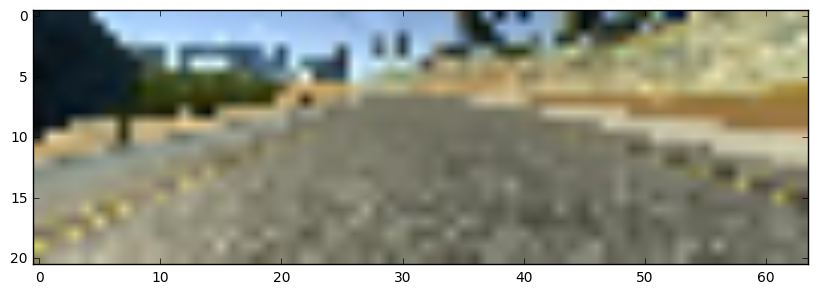

In [1]:
from keras.layers import Flatten, Dense, Activation, Convolution2D, MaxPooling2D, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import numpy as np
import csv
import cv2
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline

data_path = os.path.join(os.getcwd(), "udacity-data")

def read_image(filename):
    filename = os.path.join(data_path, filename.strip())
    bgr = cv2.imread(filename)
    cropped = bgr[30:135, 0:320]
    rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    return cv2.resize(rgb, (0,0), fx=0.2, fy=0.2)

def random_flip(image, angle):
    # randomly flip the image and angle
    if np.random.sample() > 0.5:
        old_image = image
        old_angle = angle
        image = cv2.flip(image, 1)
        angle = angle * -1.0
    return (image, angle)

class Frame:
    def __init__(self, row):
        self.center_image = row[0]
        self.left_image = row[1]
        self.right_image = row[2]
        self.steering_angle = float(row[3])
        self.throttle = float(row[4])
        self.brake = float(row[5])
        self.speed = float(row[6])
        
    def load_validation_data(self):
        image = read_image(self.center_image)
        return random_flip(image, self.steering_angle)
        
    def load_training_data(self):
        camera = np.random.randint(0,3)
        if camera == 0:
            image_name = self.center_image
            offset = 0
        elif camera == 1:
            image_name = self.left_image
            offset = 0.11
        elif camera == 2:
            image_name = self.right_image
            offset = -0.11
            
        angle = self.steering_angle + offset
        image = read_image(image_name)
        image, angle = random_flip(image, angle)
        return (image, angle)
        
def load_frames():
    with open(os.path.join(data_path, "driving_log.csv")) as f:
        reader = csv.reader(f, delimiter=",")
        next(reader) # discard header row
        return [Frame(row) for row in reader]

frames = load_frames()
num_frames = len(frames)

def frame_generator(frames, batch_size=128, training=True):
    while True:
        images = []
        angles = []
        
        for index in np.random.choice(num_frames, batch_size):
            frame = frames[index]
            
            if training:
                image, angle = frame.load_training_data()
            else:
                image, angle = frame.load_validation_data()

            images.append(image)
            angles.append(angle)
            
        yield (np.array(images), np.array(angles))

# use the generator to produce an example output image
g = frame_generator(frames, batch_size=1, training=True)
images, angles = next(g)

plt.figure(figsize=(10,10))
plt.imshow(images[0])

print("number of frames: {}".format(num_frames))
print("batch len: {},{}".format(len(images), len(angles)))


In [2]:
input_shape = images[0].shape

print("shape: {}".format(input_shape))

model = Sequential()
model.add(Lambda(lambda x: x/128.0 - 1.0,input_shape=input_shape))
model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='relu', input_shape=input_shape))
model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu', input_shape=input_shape))
model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu', input_shape=input_shape))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', subsample=(2,2), input_shape=input_shape))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', subsample=(2,2), input_shape=input_shape))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()


shape: (21, 64, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 21, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 17, 60, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 13, 56, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 9, 52, 48)     43248       convolution2d_2[0][0]            
________________________________________________________________________

In [ ]:
def round_to(x, base=1):
    return int(base * round(float(x)/base))

batch_size = 256
validation_split = 0.2
num_samples = num_frames * 3 # due to data augmentation
num_train_samples = round_to((1.0 - validation_split) * num_samples, base=batch_size)
num_val_samples = round_to(num_samples - num_train_samples, base=batch_size)

data_gen = frame_generator(frames, batch_size=batch_size, training=True)
val_gen = frame_generator(frames, batch_size=batch_size, training=False)

print("batch_size: {}".format(batch_size))
print("num_train_samples: {}".format(num_train_samples))
print("num_val_samples: {}".format(num_val_samples))

# train the model
model.fit_generator(data_gen, samples_per_epoch=num_train_samples, nb_epoch=10, validation_data=val_gen, nb_val_samples=num_val_samples)

# save the results
with open('model.json', mode='w', encoding='utf8') as f:
    f.write(model.to_json())

model.save_weights('model.h5')

print("Model saved")


batch_size: 256
num_train_samples: 19200
num_val_samples: 4864
Epoch 1/10
19200/19200 [==============================] - 120s - loss: 0.0144 - acc: 0.1785 - val_loss: 0.0099 - val_acc: 0.5461